# Neural Networks

### Introduction 

This notebook contains our neural network analyses that were performed on the data downloaded from [UCI machine learning repository](http://archive.ics.uci.edu/ml/datasets/Smartphone-Based+Recognition+of+Human+Activities+and+Postural+Transitions)

We will be using the train/test data provided in order to use neural network models to identify which activity is being performed based off of phone sensor data.

First, we'll start off by importing our required libraries for this analysis

In [39]:
# importing basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Specific neural network models & layer types
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Embedding, LSTM, GRU, BatchNormalization, TimeDistributed
from keras.layers.convolutional import Conv1D, MaxPooling1D
from tensorflow.keras.utils import timeseries_dataset_from_array

# Data reformatting
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Ignore futurewarnings
import warnings
warnings.filterwarnings('ignore')

The way this data is read is explained in `01 Basic_EDA.ipynb` 

In [40]:
# reading in the data
columns = pd.read_csv('data/features2.txt', header = None)

X_train_orig = pd.read_csv('data/Train/X_train.txt', names = columns[0], sep=' ')
X_test_orig = pd.read_csv('data/Test/X_test.txt', names = columns[0], sep=' ')

y_train_orig = pd.read_csv('data/Train/y_train.txt', sep=' ', header = None)
y_test_orig = pd.read_csv('data/Test/y_test.txt', sep=' ', header = None)

For our recurrent neural network model, we'll need to reformat our data into arrays in order to create the input window with the `.timeseries_dataset_from_array` method. We do this by using the pandas `.values` function.

In [41]:
X_train = X_train_orig.values
X_test = X_test_orig.values

We will also one hot encode our target data because we have a total of 12 targets.

In [42]:
# One hot encoding target data
ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train_orig).toarray()
y_test = ohe.fit_transform(y_test_orig).toarray()

Now, we'll also prepare some train and validation sets, with the validation sets being 10% of the total train data. This is to refine our models.

In [43]:
# split train and validation set for OHE data
X_train2, X_validation, y_train2, y_validation = train_test_split(X_train, y_train, test_size=0.1)

### PLAN

For neural networks, our goal is to first try a simple fully connected NN with a few layers, first ignoring the time component and previous activity. 

Then second, we will create a recurrent neural network by feeding in 20 time-steps and perform some sequential classification, predicting the current/next movement.

### Building a Neural Network Using Keras

The process of building a network using Keras can generally be broken down into four separate steps:
1. **Build the model**: This is the step where we will declare the structure of the network — primarily the types and sizes of the hidden layers.
2. **Compile the model**: This step allows us to customize some of the settings that will be used for training.
3. **Train the model**
4. **Evaluate the model and generate predictions**

### Fully Connected Neural Network

For our fully connect neural networks, we'll be using the following parameters:

- softmax output layer: ensures all probabilities add up to 1
- adam optimizer: best adaptive optimizer and is good with datasets with large number of features
- sparse categorical crossentropy loss function: obtains cross entropy between labels and predictions
- sparse categorical accuracy metric: for multivariate classification

#### 3 Layer NN

We will start building our model by instantiating the sequential mode, adding layers, then compiling the model.

In [46]:
# Create a new sequential model
model = keras.Sequential()

# Declare the hidden layers
# We'll be using the RELU activation function for our layers for the unbound benefit
# Dense layers will be used to create a fully connected neural network model

model.add(layers.Dense(40, activation="relu"))
model.add(layers.Dense(40, activation="relu"))
model.add(layers.Dense(40, activation="relu"))


# Declare the output layer
# Our output layer has 12 units for the 12 different activities to be classified
# There are 6 main actions, and 6 transition actions
# Transition actions are when the participant transitions to the next position
model.add(layers.Dense(13, activation="softmax"))

# Compile the model
model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),  
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

Now we'll fit our model with the train data

In [47]:
# Fit the model
history = model.fit(X_train_orig, y_train_orig, epochs=100, verbose=0)

Then we will test the accuracy of our model and compare it to the train accuracy.

In [48]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["sparse_categorical_accuracy"][-1]
result = model.evaluate(X_test_orig, y_test_orig, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")

predictions = model.predict(X_test_orig)

Train Accuracy: 0.9946
Test Accuracy: 0.9194


With a train accuracy of 99.46% and a test accuracy of 91.94%, this is a very good start. The high train accuracy scores along with the test accuracy not being too far behind indicate that the model isn't overfit and is performing very well.

Let's try taking a look at a neural network model with 5 layers.

#### 5 Layer NN 

We will follow the same steps as above to build, compile and train the neural network model.

In [61]:
# Create a new sequential model
model = keras.Sequential()

# Declare the hidden layers
# We'll be using the RELU activation function for our layers for the unbound benefit
# Dense layers will be used to create a fully connected neural network model

model.add(layers.Dense(40, activation="relu"))
model.add(layers.Dense(40, activation="relu"))
model.add(layers.Dense(40, activation="relu"))
model.add(layers.Dense(40, activation="relu"))
model.add(layers.Dense(40, activation="relu"))

# Declare the output layer
# Our output layer has 12 units for the 12 different activities to be classified
# There are 6 main actions, and 6 transition actions
# Transition actions are when the participant transitions to the next position
model.add(layers.Dense(13, activation="softmax"))

# Compile the model
model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),  
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

Now we will fit the model on our train data, with the same number of epochs as our 3-layer model.

In [62]:
# Fit the model
history = model.fit(X_train_orig, y_train_orig, epochs=100, verbose=1)

Epoch 1/100
243/243 [==============================] - 1s 1ms/step - loss: 0.8520 - sparse_categorical_accuracy: 0.6710
Epoch 2/100
243/243 [==============================] - 0s 1ms/step - loss: 0.2736 - sparse_categorical_accuracy: 0.8926
Epoch 3/100
243/243 [==============================] - 0s 1ms/step - loss: 0.1765 - sparse_categorical_accuracy: 0.9279
Epoch 4/100
243/243 [==============================] - 0s 1ms/step - loss: 0.1439 - sparse_categorical_accuracy: 0.9426
Epoch 5/100
243/243 [==============================] - 0s 1ms/step - loss: 0.1358 - sparse_categorical_accuracy: 0.9441
Epoch 6/100
243/243 [==============================] - 0s 1ms/step - loss: 0.1118 - sparse_categorical_accuracy: 0.9552
Epoch 7/100
243/243 [==============================] - 0s 1ms/step - loss: 0.1084 - sparse_categorical_accuracy: 0.9571
Epoch 8/100
243/243 [==============================] - 0s 1ms/step - loss: 0.1115 - sparse_categorical_accuracy: 0.9548
Epoch 9/100
243/243 [===================

Now we can evaluate our model on the test data.

In [65]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["sparse_categorical_accuracy"][-1]
result = model.evaluate(X_test_orig, y_test_orig, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")

predictions = model.predict(X_test_orig)

Train Accuracy: 0.9898
Test Accuracy: 0.9405


Look at that! Although our train accuracy is slightly lower, we have a smaller gap between the train and test accuracys when compared to the 3-layer model.

| Model | Train Accuracy | Test Accuracy |
| --- | --- | --- |
| 3-Layer | 99.46% | 91.94% |
| 5-Layer | 98.98% | 94.05% |

### Recurrent Neural Network

Let's now take a look at how well a recurrent neural network (RNN) does with this data. 

In this analysis, we'll be building a RNN model that has a window size of 20, and the model will evaluate all activities at once to make a prediction.
The window size allows the prediction to be made on the 20 records, performing a one shot prediction.

To create these windows, we'll use the `.timeseries_dataset_from_array` function from the tensorflow, keras library. This function requres an array input in order to easily split the data into a format compatible with the RNN.

- The sample_length = window size
- The stride is the period between successive output sequences
- Batch size is set to a number that would include all records of our data for the train and validation sets
- Shuffle = False because we don't want to reorganize our timeseries data

In [66]:
sample_length = 20
stride = 5

X_train3 = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_train2, None, sequence_length=sample_length, sequence_stride=stride, shuffle=False, batch_size = 540)
y_train3 = tf.keras.preprocessing.timeseries_dataset_from_array(
  y_train2, None, sequence_length=sample_length, sequence_stride=stride, shuffle=False, batch_size = 540)
X_val = tf.keras.preprocessing.timeseries_dataset_from_array(
  X_validation, None, sequence_length=sample_length, sequence_stride=stride, shuffle=False, batch_size = 60)
y_val = tf.keras.preprocessing.timeseries_dataset_from_array(
  y_validation, None, sequence_length=sample_length, sequence_stride=stride, shuffle=False, batch_size = 60)

# create datasets for the training RNN input and target
for batch in zip(X_train3, y_train3):
    inputs, targets = batch
    break
    
# create datasets for the validation RNN input and target
for batch in zip(X_val, y_val):
    input_val, target_val = batch
    break

In [67]:
print(f"The shape of the X_train data is: {X_train2.shape}")
print(f"The shape of the y_train data is: {y_train2.shape}")
print(f"The shape of the X_validation data is: {X_validation.shape}")
print(f"The shape of the y_validation data is: {y_validation.shape}")

The shape of the X_train data is: (6990, 561)
The shape of the y_train data is: (6990, 12)
The shape of the X_validation data is: (777, 561)
The shape of the y_validation data is: (777, 12)


In [68]:
print(f"The shape of the inputs data is: {inputs.shape}")
print(f"The shape of the targets data is: {targets.shape}")
print(f"The shape of the validation input data is: {input_val.shape}")
print(f"The shape of the validation targets data is: {target_val.shape}")

The shape of the inputs data is: (540, 20, 561)
The shape of the targets data is: (540, 20, 12)
The shape of the validation input data is: (60, 20, 561)
The shape of the validation targets data is: (60, 20, 12)


Now that our data is split up properly, we can see that our shapes are looking good. There are the proper number of features and targets, and the window size is also looking good. Let's move on to building the RNN.

Here are some of the reasons as to why we built the model the way we did.

- GRU is like LSTM, but with less features with a forget gate and performs similar to the LSTM.
- Number of Nodes is arbitrary
- activation function of `relu` seemed like a safe and very common choice
- return_sequences is required for our RNN to obtain a sequence as the output instead of a single vector
- softmax output to ensure all output values add up to 1
- dropout layers help with overfitting
- batch normalization standardizes inputs and accelerates training time

In [73]:
# instantiate the model
RNN = Sequential()
RNN.add(GRU(128, activation='relu', return_sequences=True))

RNN.add(GRU(64, activation='relu', return_sequences=True))
RNN.add(BatchNormalization())
RNN.add(Dropout(0.15))

RNN.add(GRU(32, activation='relu', return_sequences=True))
RNN.add(BatchNormalization())
RNN.add(Dropout(0.15))

RNN.add(Dense(16, activation='relu'))
RNN.add(BatchNormalization())
RNN.add(Dropout(0.15))

RNN.add(Dense(12, activation='softmax'))

Now that the model is built, let's compile our model and fit it on our reformatted data.

In [74]:
# Compile model
RNN.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy']
)

In [75]:
history = RNN.fit(inputs, targets,
        epochs=20,
        validation_data=(input_val, target_val),
        verbose = 0)

---

#### RNN Model Evaluation

Everything is now complete, let's take a look at our model performance by plotting our train and validation loss and accuracy.

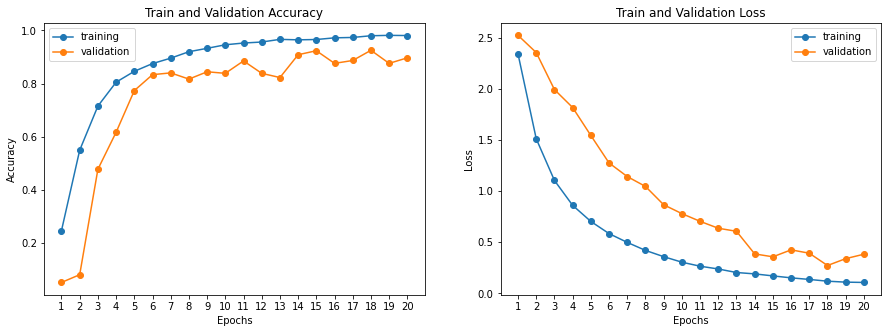

In [82]:
epochs = range(1, 21)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], label="training", marker="o")
plt.plot(epochs, history.history["val_accuracy"], label="validation", marker="o")
plt.title('Train and Validation Accuracy')
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], label="training", marker="o")
plt.plot(epochs, history.history["val_loss"], label="validation", marker="o")
plt.title('Train and Validation Loss')
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Loss")
plt.legend()
plt.savefig('score.png', transparent=True)
plt.show()

This model is looking really good, performance seems to be doing really well. 

The trends for the train and validation accuracies are both uptrending, and do not hover around a certain level, which means there's no indication of overfitting.

The trends for the train and validation losses both show that they're approaching zero over time, and again, there's no hovering around a constant value, meaning there's no indication of overfitting.

In [77]:
# Display its summary
RNN.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_12 (GRU)                 (None, 20, 128)           265344    
_________________________________________________________________
gru_13 (GRU)                 (None, 20, 64)            37248     
_________________________________________________________________
batch_normalization_12 (Batc (None, 20, 64)            256       
_________________________________________________________________
dropout_12 (Dropout)         (None, 20, 64)            0         
_________________________________________________________________
gru_14 (GRU)                 (None, 20, 32)            9408      
_________________________________________________________________
batch_normalization_13 (Batc (None, 20, 32)            128       
_________________________________________________________________
dropout_13 (Dropout)         (None, 20, 32)           

---